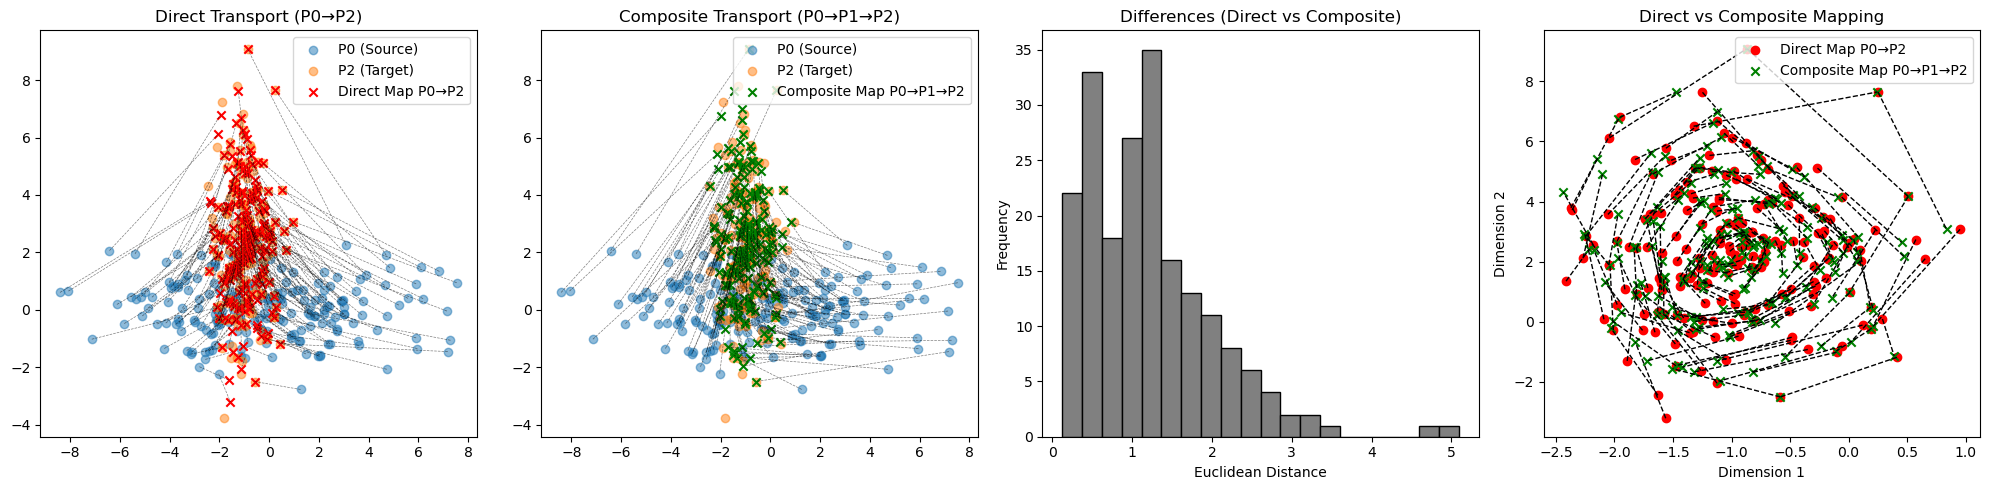

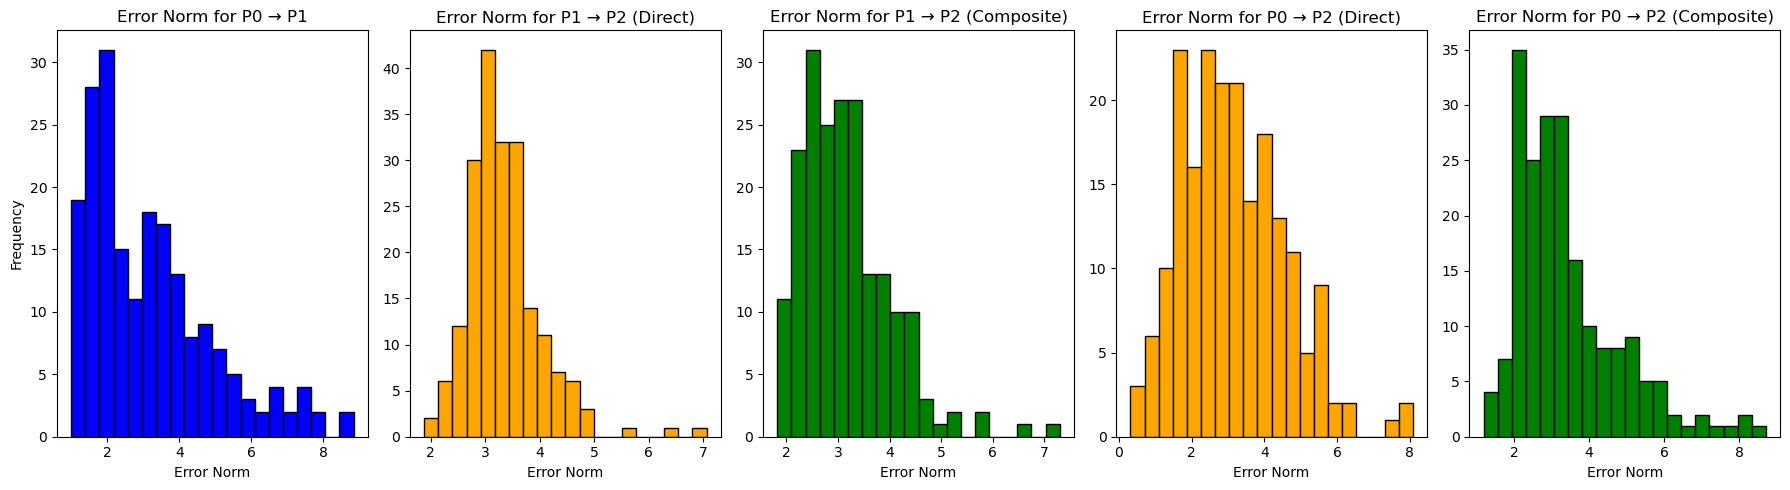

Average error norm for P0 → P1: 3.1836710156741606
Average error norm for P1 → P2 (Direct): 3.3509301301265224
Average error norm for P1 → P2 (Composite): 3.146281625732011
Average error norm for P0 → P2 (Direct): 3.1591884276490316
Average error norm for P0 → P2 (Composite): 3.4129162852330843
Counterfactual inconsistency (RMSE): 1.0249294


In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# OTT-JAX imports
from ott.geometry import pointcloud
from ott.solvers.linear import solve
from ott.geometry.costs import PNormP

# ---------------------------------------------------------------------------
# Define a function to compute the entropic map using OTT-JAX
def entropic_map(x: jnp.ndarray,
                 y: jnp.ndarray,
                 cost_fn: PNormP,
                 epsilon: float = 0.1):
    """
    Compute the entropic OT map between x and y using OTT-JAX.
    Returns dual potentials with a transport method for out-of-sample extension.
    """
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn, epsilon=epsilon)
    output = solve(geom)
    dual_potentials = output.to_dual_potentials()
    return dual_potentials

# ---------------------------------------------------------------------------
# Set seed for reproducibility and define sample sizes/dimension
# Fix random seed for reproducibility
np.random.seed(0)

# Define three 2D Gaussians (means and covariances)
m0 = np.array([0.0, 0.0])
S0 = np.array([[10.0, 0.0],
               [0.0, 1.0]])

m1 = np.array([1.0, 1.0])
S1 = np.array([[1, -0.9],
               [-0.9, 1.0]])

m2 = np.array([-1.0, 2.0])
S2 = np.array([[0.5, 0.0],
               [0.0, 5]])

# Draw samples
n0 = n1 = n2 = 200
P0_np = np.random.multivariate_normal(m0, S0, size=n0)
P1_np = np.random.multivariate_normal(m1, S1, size=n1)
P2_np = np.random.multivariate_normal(m2, S2, size=n2)


# Convert data to jax arrays
P0 = jnp.array(P0_np)
P1 = jnp.array(P1_np)
P2 = jnp.array(P2_np)

# Define uniform weights implicitly in the geometry (handled by OTT)

# Define the cost function (QuadraticCost corresponds to squared Euclidean distance)
cost_fn = PNormP(p=2.0) #SqEuclidean()

# Set regularization parameter
epsilon = 1e-2

# ---------------------------------------------------------------------------
# Compute entropic maps using the OTT-JAX method
# Map from P0 -> P1
map_01 = entropic_map(P0, P1, cost_fn, epsilon=epsilon)
Tmap_01 = np.array(map_01.transport(P0))  # out-of-sample extension: transport P0 to P1

# Map from P1 -> P2
map_12 = entropic_map(P1, P2, cost_fn, epsilon=epsilon)
Tmap_12 = np.array(map_12.transport(P1))  # in-sample mapping from P1 to P2

# Map from P0 -> P2 (direct)
map_02 = entropic_map(P0, P2, cost_fn, epsilon=epsilon)
Tmap_02 = np.array(map_02.transport(P0))  # direct mapping from P0 to P2

# ---------------------------------------------------------------------------
# Compose the mapping: P0 -> P1 -> P2
# Instead of using a nearest-neighbor search, we use the out-of-sample extension.
# That is, we first map P0 to P1 using map_01, and then map these points via map_12.
Tmap_012 = np.array(map_12.transport(Tmap_01))

# ---------------------------------------------------------------------------
# Compute distances between the direct and composite maps (for reference)
diff = Tmap_02 - Tmap_012
distances = np.linalg.norm(diff, axis=1)

# ---------------------------------------------------------------------------
# Plot the results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: Direct Transport (P0 -> P2)
axes[0].scatter(P0_np[:, 0], P0_np[:, 1], label='P0 (Source)', alpha=0.5)
axes[0].scatter(P2_np[:, 0], P2_np[:, 1], label='P2 (Target)', alpha=0.5)
axes[0].scatter(Tmap_02[:, 0], Tmap_02[:, 1], marker='x', color='red', label='Direct Map P0→P2')
for i in range(n0):
    axes[0].plot([P0_np[i, 0], Tmap_02[i, 0]], [P0_np[i, 1], Tmap_02[i, 1]], 'k--', linewidth=0.5, alpha=0.5)
axes[0].set_title('Direct Transport (P0→P2)')
axes[0].legend()

# Plot 2: Composite Transport (P0 -> P1 -> P2)
axes[1].scatter(P0_np[:, 0], P0_np[:, 1], label='P0 (Source)', alpha=0.5)
axes[1].scatter(P2_np[:, 0], P2_np[:, 1], label='P2 (Target)', alpha=0.5)
axes[1].scatter(Tmap_012[:, 0], Tmap_012[:, 1], marker='x', color='green', label='Composite Map P0→P1→P2')
for i in range(n0):
    axes[1].plot([P0_np[i, 0], Tmap_012[i, 0]], [P0_np[i, 1], Tmap_012[i, 1]], 'k--', linewidth=0.5, alpha=0.5)
axes[1].set_title('Composite Transport (P0→P1→P2)')
axes[1].legend()

# Plot 3: Histogram of differences between direct and composite mappings
axes[2].hist(distances, bins=20, color='gray', edgecolor='black')
axes[2].set_title('Differences (Direct vs Composite)')
axes[2].set_xlabel('Euclidean Distance')
axes[2].set_ylabel('Frequency')

# Plot 4: Overlay of Direct vs Composite mappings
axes[3].scatter(Tmap_02[:, 0], Tmap_02[:, 1], color='red', label='Direct Map P0→P2', marker='o')
axes[3].scatter(Tmap_012[:, 0], Tmap_012[:, 1], color='green', label='Composite Map P0→P1→P2', marker='x')
for i in range(n0):
    axes[3].plot([Tmap_02[i, 0], Tmap_012[i, 0]], [Tmap_02[i, 1], Tmap_012[i, 1]], 'k--', linewidth=1.0)
axes[3].set_title('Direct vs Composite Mapping')
axes[3].set_xlabel('Dimension 1')
axes[3].set_ylabel('Dimension 2')
axes[3].legend()

plt.tight_layout()
plt.show()

# --------------------------
# Compute estimated differences and compare to the true counterfactual shifts.
# In our example:
#   True difference for P0 -> P1: (3, 3)
#   True difference for P1 -> P2: (P2 shift - P1 shift) = ([-2, 4] - [3, 3]) = (-5, 1)
#   Thus, the true difference for P0 -> P2 is (3, 3) + (-5, 1) = (-2, 4)

true_diff_01 = np.array([3, 3])
true_diff_21 = np.array([-5, 1])
true_diff_20 = true_diff_01 + true_diff_21  # equals [-2, 4]

# Estimated differences:
# For P0 -> P1: computed from the mapping Tmap_01
diff_est_01 = Tmap_01 - P0_np  # Tmap_01 from the entropic map P0 -> P1

# For P1 -> P2, we have two estimates:
# (a) Directly from the direct mapping: (Tmap_02 - Tmap_01)
diff_est_21_direct = Tmap_02 - Tmap_01
# (b) Using the composite mapping: (Tmap_012 - Tmap_01)
diff_est_21_composite = Tmap_012 - Tmap_01

# For P0 -> P2, again two estimates:
# (a) Direct mapping: (Tmap_02 - P0)
diff_est_20_direct = Tmap_02 - P0_np
# (b) Composite mapping: (Tmap_012 - P0)
diff_est_20_composite = Tmap_012 - P0_np

# Compute errors relative to the true differences:
error_01 = diff_est_01 - true_diff_01
error_21_direct = diff_est_21_direct - true_diff_21
error_21_composite = diff_est_21_composite - true_diff_21
error_20_direct = diff_est_20_direct - true_diff_20
error_20_composite = diff_est_20_composite - true_diff_20

# Compute Euclidean norms of these errors for a quantitative measure:
norm_error_01 = np.linalg.norm(error_01, axis=1)
norm_error_21_direct = np.linalg.norm(error_21_direct, axis=1)
norm_error_21_composite = np.linalg.norm(error_21_composite, axis=1)
norm_error_20_direct = np.linalg.norm(error_20_direct, axis=1)
norm_error_20_composite = np.linalg.norm(error_20_composite, axis=1)

# Plot histograms of these error norms:
fig2, axes2 = plt.subplots(1, 5, figsize=(18, 5))

axes2[0].hist(norm_error_01, bins=20, color='blue', edgecolor='black')
axes2[0].set_title('Error Norm for P0 → P1')
axes2[0].set_xlabel('Error Norm')
axes2[0].set_ylabel('Frequency')

axes2[1].hist(norm_error_21_direct, bins=20, color='orange', edgecolor='black')
axes2[1].set_title('Error Norm for P1 → P2 (Direct)')
axes2[1].set_xlabel('Error Norm')

axes2[2].hist(norm_error_21_composite, bins=20, color='green', edgecolor='black')
axes2[2].set_title('Error Norm for P1 → P2 (Composite)')
axes2[2].set_xlabel('Error Norm')

axes2[3].hist(norm_error_20_direct, bins=20, color='orange', edgecolor='black')
axes2[3].set_title('Error Norm for P0 → P2 (Direct)')
axes2[3].set_xlabel('Error Norm')

axes2[4].hist(norm_error_20_composite, bins=20, color='green', edgecolor='black')
axes2[4].set_title('Error Norm for P0 → P2 (Composite)')
axes2[4].set_xlabel('Error Norm')

plt.tight_layout()
plt.show()

# Optionally, print the average error norms and overall inconsistency:
print("Average error norm for P0 → P1:", np.mean(norm_error_01))
print("Average error norm for P1 → P2 (Direct):", np.mean(norm_error_21_direct))
print("Average error norm for P1 → P2 (Composite):", np.mean(norm_error_21_composite))
print("Average error norm for P0 → P2 (Direct):", np.mean(norm_error_20_direct))
print("Average error norm for P0 → P2 (Composite):", np.mean(norm_error_20_composite))
print("Counterfactual inconsistency (RMSE):", np.sqrt(np.mean((Tmap_02 - Tmap_012)**2)))